In [1]:
import numpy as np
import pandas as pd
df=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [2]:
import pandas as pd

# Count the number of 0s and 1s in the 'isFraud' column
fraud_counts = df['isFraud'].value_counts()

# Print the result
print(fraud_counts)

0    6354407
1       8213
Name: isFraud, dtype: int64


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['type'])
label
df.drop("type", axis=1, inplace=True)
df["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameDest'])
label
df.drop("nameDest", axis=1, inplace=True)
df["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameOrig'])
label
df.drop("nameOrig", axis=1, inplace=True)
df["nameOrig"] = label

In [4]:
X = df.drop('isFraud', axis=1)
# Separate the target variable
y = df['isFraud']

In [5]:
from imblearn.over_sampling import SMOTE

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.55, random_state=0)

# Fit and apply the resampler to the entire dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [6]:
counts = y_resampled.value_counts()
print(counts)

0    6354407
1    3494923
Name: isFraud, dtype: int64


In [7]:
import csv
import random

# number of data points to sample from original dataset
k= 1500000

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = []
    for i, line in enumerate(f):
        if i < k:
            sampled_lines.append(line)
        else:
            j = random.randint(0, i)
            if j < k:
                sampled_lines[j] = line

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

In [8]:
df_sample_big=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv")

In [9]:
from sklearn.model_selection import train_test_split

X = df_sample_big.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample_big['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, stratify=y_resampled, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.99874
1    0.00126
Name: isFraud, dtype: float64
0    0.645161
1    0.354839
Name: isFraud, dtype: float64
0    0.645162
1    0.354838
Name: isFraud, dtype: float64


In [10]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)

In [11]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [12]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [13]:
# import the necessary libraries
import pandas as pd
import numpy as np
# convert X_test to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=X_train_resampled_final.columns)
# define a function to replace outliers with MAD for a single column
def replace_outliers_with_mad(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    threshold = 2.5 * mad
    column[np.abs(column - median) > threshold] = median
    return column

# apply the function to all columns of X_train_resampled_final
for i in range(X_train_resampled_final.shape[1]):
    X_train_resampled_final.iloc[:, i] = replace_outliers_with_mad(X_train_resampled_final.iloc[:, i])

# apply the function to all columns of X_test
for i in range(X_test.shape[1]):
    X_test.iloc[:, i] = replace_outliers_with_mad(X_test.iloc[:, i])

# convert the numpy arrays back to pandas dataframes
X_train_resampled_final = pd.DataFrame(X_train_resampled_final, columns=X_train_resampled_final.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# print the modified dataframes
print(X_train_resampled_final)
print(X_test)

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


         step         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         398   96046.150000     576.000000             0.0        0.000000   
1         144    9664.660000     135.000000             0.0        0.000000   
2         212    3535.920000  101588.000000             0.0        0.000000   
3         284   18362.990000   25965.350000             0.0     5311.241300   
4         349  137265.306917       0.000000             0.0     5311.241300   
...       ...            ...            ...             ...             ...   
8823989    93  137265.306917   62831.000000             0.0     5311.241300   
8823990   285  137265.306917   62831.000000             0.0       32.745541   
8823991   327  137265.306917   62831.000000             0.0     5311.241300   
8823992   323  100140.215276  100140.215276             0.0        0.000000   
8823993   409  165893.714023  165893.714023             0.0        0.000000   

         newbalanceDest  isFlaggedFraud  type  name

In [14]:
df_sample_big = df_sample_big.reset_index(drop=True)

In [15]:
X_train_resampled_final = X_train_resampled_final.reset_index(drop=True)

In [16]:
y_train_resampled_final = y_train_resampled_final.reset_index(drop=True)

In [84]:
# Define the model architecture
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,10, 1)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

import numpy as np

# Convert DataFrame to numpy array
X_train_resampled_final_arr = X_train_resampled_final.values

X_train_resampled_final_arr = X_train_resampled_final_arr.reshape(X_train_resampled_final_arr.shape[0], 1, 10, 1)

# Train the model
model.fit(X_train_resampled_final_arr, y_train_resampled_final, epochs=10, batch_size=64)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
137875/137875 [==============================] - 682s 5ms/step - loss: 0.8562 - accuracy: 0.6436
Epoch 2/10
137875/137875 [==============================] - 667s 5ms/step - loss: 0.6537 - accuracy: 0.6435
Epoch 3/10
137875/137875 [==============================] - 680s 5ms/step - loss: 0.6514 - accuracy: 0.6435
Epoch 4/10
137875/137875 [============================

In [92]:
import numpy as np

# Convert DataFrame to numpy array
X_test_arr = np.array(X_test.values)

X_test_arr = X_test_arr.reshape(X_test_arr.shape[0], 1, 10, 1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_arr, y_test)

# Generate predicted probabilities for the test set
y_pred_prob = model.predict(X_test_arr)

# Set the threshold for converting probabilities to class labels
threshold = 0.1

# Convert predicted probabilities to class labels using the threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Calculate the f1 score, precision, and recall
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)

30780/30780 [==============================] - 81s 3ms/step
Test Loss: 0.6503358483314514
F1 Score: 0.5238091312737696
Precision: 0.354838349410569
Recall: 1.0


30780/30780 [==============================] - 87s 3ms/step


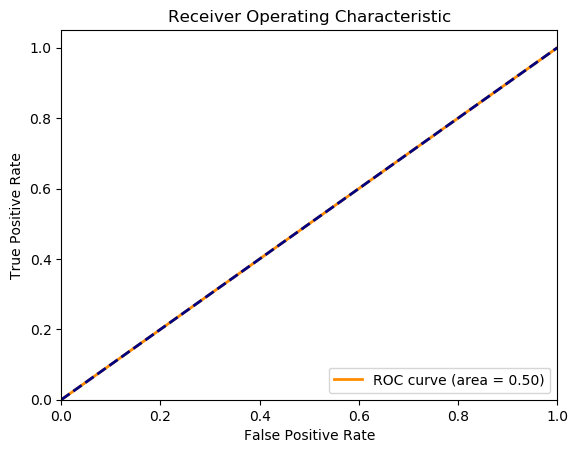

In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set
y_pred_prob = model.predict(X_test_arr)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [79]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, None, 8, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, None, 6, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, None, 384)        0         
 stributed)                                                      
                                                                 
 lstm_36 (LSTM)              (None, 50)                87000     
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                     

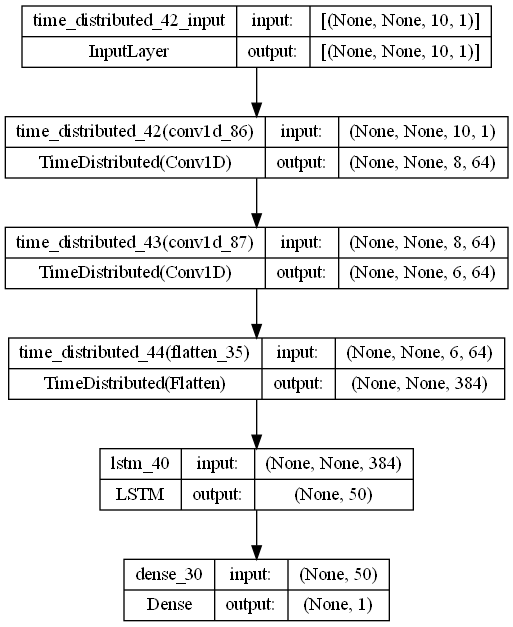

In [96]:
from keras.utils import plot_model
plot_model(model, to_file='a_new.png', show_shapes=True)